In [1]:
#https://www.tensorflow.org/tutorials/keras/classification
import tensorflow as tf
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:

#define the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10),
    keras.layers.Softmax()
])


In [3]:
# compile the keras model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [4]:
#Extract the MNIST images and labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)


Data shapes (10000, 28, 28) (10000,) (60000, 28, 28) (60000,)


In [5]:
# fit the keras model on the dataset
model.fit(x_train, y_train,
          batch_size=32,
          epochs=5,
          validation_data=(x_test, y_test))

# evaluate the keras model
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)
# evaluate the keras model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTrain accuracy:', train_acc)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5711 - accuracy: 0.9054 - val_loss: 1.5295 - val_accuracy: 0.9366
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.5170 - accuracy: 0.9493 - val_loss: 1.5093 - val_accuracy: 0.9547
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.5033 - accuracy: 0.9612 - val_loss: 1.5001 - val_accuracy: 0.9650
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4945 - accuracy: 0.9699 - val_loss: 1.4992 - val_accuracy: 0.9647
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4893 - accuracy: 0.9744 - val_loss: 1.4928 - val_accuracy: 0.9700
1875/1875 - 3s - loss: 1.4835 - accuracy: 0.9798
313/313 - 0s - loss: 1.4928 - accuracy: 0.9700

Train accuracy: 0.9797999858856201

Test accuracy: 0.9700000286102295


In [6]:

test_predictions = model.predict(x_test)
train_predictions = model.predict(x_train)

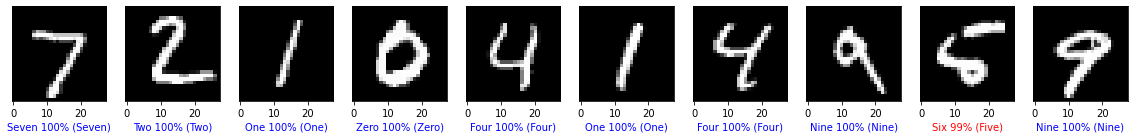

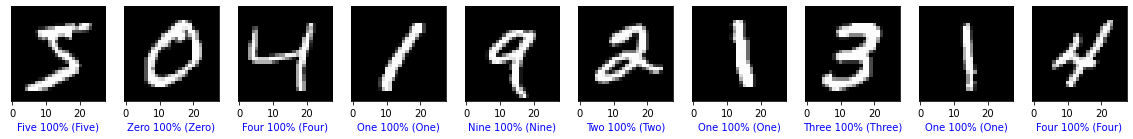

In [7]:
class_names = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine']

def display_images(images, predicted_labels, true_labels):
  '''
  Display the images in an orderly way that associates it with its predicted and true labels.
  :images: the input images
  :predicted_labels: the predicted labels from the model
  :true_labels: the correct labels
  '''
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28))
        plt.gray()
        ax.get_yaxis().set_visible(False)

        predicted_label = np.argmax(predicted_labels[i])

        if predicted_label == true_labels[i]:
          color = 'blue'
        else:
          color = 'red'

        plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100*np.max(predicted_labels[i]),
                                      class_names[true_labels[i]]),
                                      color=color)


    plt.show()

display_images(x_test, test_predictions, y_test)
display_images(x_train, train_predictions, y_train)

Now, create an FGSM adversarial attack function that perturbs the data using the formula
$$\text{Untargeted: }x' = x + \epsilon.sign(\nabla_xl(x,y))$$

In [8]:
#Define the categorical cross-entropy loss object
loss_object = keras.losses.CategoricalCrossentropy(from_logits=True )

def single_adversarial_attack(input_image, input_label, eps):
  '''
  Produce a single-step adversarial attack on a single image
  :input_image: the image being attacked
  :input_label: the correct label for the image
  :eps: a hyperparameter
  '''
  #Recast the image as a tensor of the proper size and datatype
  input_image = tf.cast(input_image.reshape((1, img_rows, img_cols, channels)), tf.float32)
  
  with tf.GradientTape() as tape:
    tape.watch(input_image)

    #Get the predicted output of the i
    prediction = tf.transpose(model(input_image))
    input_label = input_label.reshape((input_label.shape[0],1))
    #Get the loss between the true and predicted label
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)

  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)


  output = input_image + signed_grad*eps
  

  return tf.reshape(output,(img_rows, img_cols))

In [32]:
def adversarial_attack(images, labels, eps):
  '''
  Perform a single-step adversarial attack on an entire dataset
  :images: the input images
  :labels: the true labels for the inputs
  :eps: a hyperparameter
  '''
  adv_images = []
  for x, y in zip(images, labels):
    adv_images.append(single_adversarial_attack(x,y,eps).numpy())

  return np.asarray(adv_images)

In [10]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
image = x_train[0]
label = y_train_categorical[0].reshape(y_train_categorical[0].shape[0],1)
x_adv = single_adversarial_attack(image, label, 0.1)


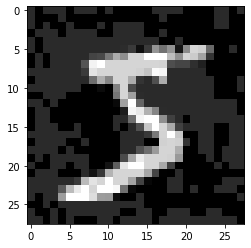

In [12]:
plt.imshow(x_adv)
plt.show()

In [13]:
#Create an attack on the training data
attack_imgs = adversarial_attack(x_train, y_train_categorical, 0.1)


In [14]:
print("Base accuracy on adversarial images:", model.evaluate(x=attack_imgs, y=y_train, verbose=0))

Base accuracy on adversarial images: [2.450824022293091, 0.007366666570305824]


In [15]:
adv_train_predictions = model.predict(attack_imgs)

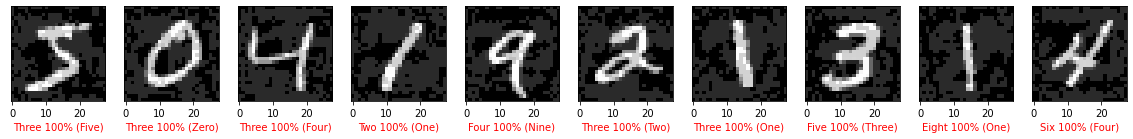

In [16]:
display_images(attack_imgs, adv_train_predictions, y_train)

Now implement a multi-step untargeted PGD adversarial attack using the formula:
$$\text{Untargeted: }x_0' = x \implies x_{N+1}' = Clip_{x,\epsilon}\{x_N' + \alpha.sign(\nabla_xl(x_n', y)\} $$

In [33]:


def single_multistep_adversarial_attack(input_image, input_label, eps, a, T):
  '''
  Produce a multi-step adversarial attack on a single image
  :input_image: the image being attacked
  :input_label: the correct label for the image
  :eps: a hyperparameter
  :a: another hyperparameter defining the step size
  :T: the number of steps to be taken
  '''

  image_temp = tf.cast(input_image.reshape((1, img_rows, img_cols, channels)), tf.float32)
      
      
  for t in range(T):
    #Define the step size
    step_size = (1 - a*t)**(-1)
      
    with tf.GradientTape() as tape:
      tape.watch(image_temp)

      #Predict the label of the image
      prediction = tf.transpose(model(image_temp))
      input_label = input_label.reshape((input_label.shape[0],1))
      #Calculate the loss between the true label and the prediction
      loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image_temp)

    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)

    image_temp = image_temp + signed_grad*step_size


  return tf.reshape(image_temp, [img_rows, img_cols])

In [34]:
def multistep_adversarial_attack(images, labels, eps, a, T):
  '''
  Perform multi-step adversarial attacks on an entire dataset
  :images: the images being attacked
  :labels: the correct labels for the images
  :eps: a hyperparameter
  :a: another hyperparameter defining the step size
  :T: the number of steps to be taken
  '''
  adv_images = []
  for i, (x, y) in enumerate(zip(images, labels)):
    adv_images.append(single_multistep_adversarial_attack(x,y,eps, a, T).numpy())

  return np.asarray(adv_images)

In [37]:
multistep_attack = single_multistep_adversarial_attack(x_train[0], y_train_categorical[0], 0.1, 0.01, 5)

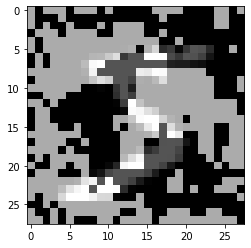

In [38]:
plt.imshow(multistep_attack)
plt.show()

In [39]:
multistep_attack_images = multistep_adversarial_attack(x_train[0:300], y_train_categorical[0:300], 0.1, 0.001, 100)

In [40]:
print("Base accuracy on adversarial images:", model.evaluate(x=multistep_attack_images, y=y_train[0:300], verbose=0))
adv_train_predictions = model.predict(multistep_attack_images)

Base accuracy on adversarial images: [2.460761785507202, 0.0]


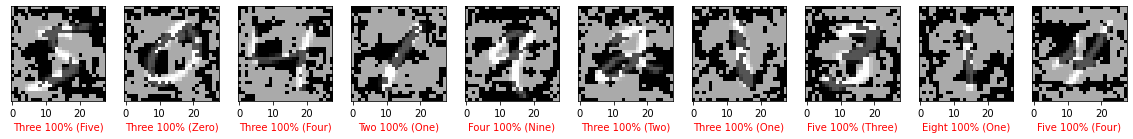

In [41]:
display_images(multistep_attack_images, adv_train_predictions, y_train[0:300])